<a href="https://colab.research.google.com/github/palashbaranwal/END3/blob/main/Session2_5/Session2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Session 2.5 : PyTorch 101

##Import Libraries 

In [3]:
import torch
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [4]:
print(torch.__version__)

1.9.0+cu111


## Calculate mean and standard deviation of MNIST

In [5]:
# simple transform
simple_transforms = transforms.Compose([transforms.ToTensor()])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


<font color="blue">  From above, we identify mean to be 0.1307 and standard deviation to be 0.3081 </font>



In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize
                                       ])

test_transforms = train_transforms

## Print an image

In [7]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [8]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [9]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(2)
2
<class 'torch.Tensor'>


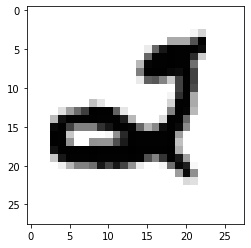

In [10]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
print(labels[0])
print(labels[0].numpy())
print(type(labels[0]))


<font color="blue">  This is a classic 2. I even tried drawing like this. :D </font>



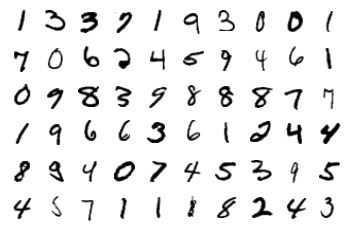

In [11]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    # plt.imshow(images[index], cmap='gray_r')

In [12]:
print(f'Number of examples in training dataset :{len(train)}')
print(f'Shape of the training dataset - images : {train.data.shape}')
print(f'Labels in the training dataset : {train.targets}')

Number of examples in training dataset :60000
Shape of the training dataset - images : torch.Size([60000, 28, 28])
Labels in the training dataset : tensor([5, 0, 4,  ..., 5, 6, 8])


# Create a custom dataset

### Why do we need a custom dataset here?

Reference - [https://pytorch.org/tutorials/beginner/data_loading_tutorial.html](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [16]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import random

class MyCustomDataset(Dataset):
  """Custom dataset to initialize data required for this project"""
  def __init__(self,myDataset):
    self.myDataset = myDataset
    
  def __len__(self):
    return(self.myDataset)

  def __getitem__(self,idx):
    """Get a random number from 0 to 9"""
    randNum = random.randint(0, 9)

    """Convert a random number to a tensor. This is required for one-ho encoding"""
    randNum_tensor = torch.tensor(randNum)

    """Get a random number from MNIST"""
    rand_image,rand_image_value = self.myDataset[index]

    """One hot encoding the random number"""
    print(type(randNum))
    randNum_OHE = F.one_hot(randNum_tensor,num_classes=10)
    print(randNum_OHE)

    """Expected Output"""
    expected_sum = randNum + rand_image_value

    """Return a tuple"""
    return_tuple = (randNum_OHE,rand_image,rand_image_value,expected_sum)

    return return_tuple



In [17]:
custom_train_dataset = MyCustomDataset(train)
custom_test_dataset = MyCustomDataset(test)

In [19]:
randomNumber,image, label1, label2 = next(iter(custom_train_dataset))
randomNumber.shape,image.shape, label1, label2

<class 'int'>
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


(torch.Size([10]), torch.Size([1, 28, 28]), 4, 11)

## Training network